In [50]:
import statsmodels.tsa as tsa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Import arima,sarimax,acf,pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import acf,pacf
# Import ExponentialSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
# import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from pmdarima import auto_arima
# Import mean_squared_error,mean_absolute_error,median_absolute_error,mean_absolute_percentage_error,r2_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error,mean_absolute_percentage_error,r2_score
# import prophet
from prophet import Prophet
from prophet.diagnostics import performance_metrics



### Import and Feature Engineering

In [2]:
# import top key words
df = pd.read_csv('dataset/top_keywords.csv')

In [3]:
df

,date,words/count
0,2012-11-10,"{'select': 5, 'alway': 5, 'time': 5, 'wine': 4..."
1,2014-04-08,"{'beer': 8, 'great': 6, 'like': 6, 'food': 5, ..."
2,2012-02-09,"{'tire': 4, 'locat': 3, 'select': 3, 'fri': 2,..."
3,2012-07-27,"{'went': 2, 'tequila': 2, 'store': 2, 'varieti..."
4,2013-04-18,"{'love': 6, 'like': 5, 'place': 4, 'italian': ..."
...,...,...
3830,2010-12-06,"{'love': 5, 'great': 4, 'reason': 3, 'coupon':..."
3831,2011-12-18,"{'decid': 4, 'go': 4, 'minut': 3, 'meal': 3, '..."
3832,2011-03-03,"{'drink': 3, 'place': 3, 'food': 3, 'group': 2..."
3833,2011-09-14,"{'kc': 6, 'seem': 3, 'larg': 3, 'pull': 3, 'po..."


In [4]:
# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
#Transform the word/count string into a dictionary
df['words/count'] = df['words/count'].apply(lambda x: eval(x))

In [5]:
# create a new dataframe with the date and the count of each word
df2 = pd.DataFrame(df['words/count'].tolist(), index=df['date'])
# fill the NaN values with 0 and convert the dataframe to int
df2.fillna(0, inplace=True)
df2 = df2.astype(int)
#Group by date and sum the count of each word by week
df2 = df2.groupby(pd.Grouper(freq='W')).sum()
# Rank the words by the sum of the count
df2 = df2.reindex(df2.sum().sort_values(ascending=False).index, axis=1)

### Data Exploration

In [6]:
df2.sum().head(10)

food      6321
good      5298
place     5075
time      4782
order     4689
great     4096
get       3797
go        3454
like      3147
servic    3091
dtype: int64

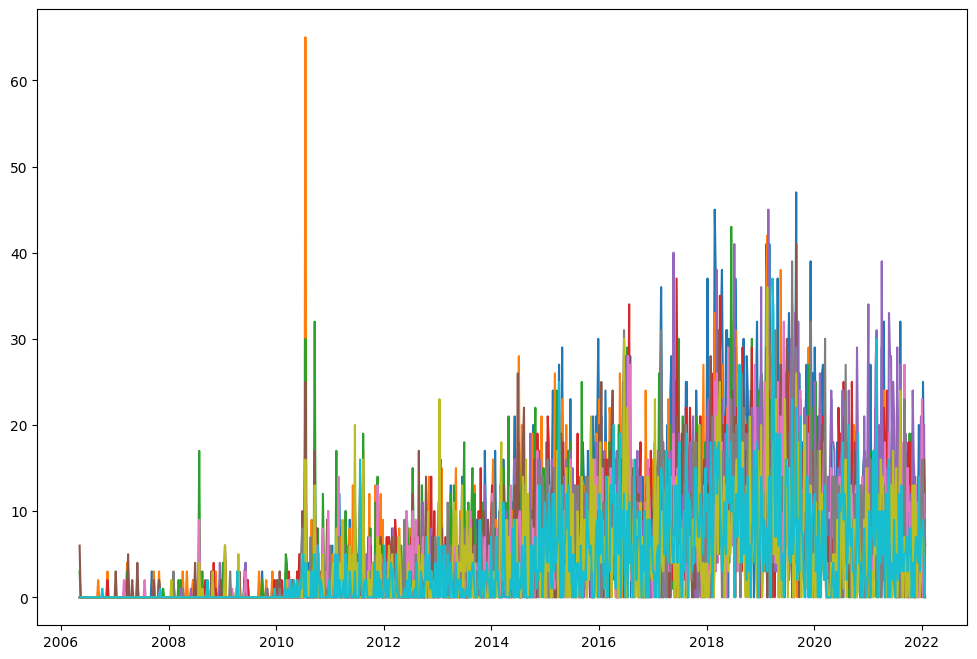

In [7]:
# Plot the top 10 words
plt.figure(figsize=(12, 8))
for i in df2.columns[:10]:
    plt.plot(df2[i], label=i)

In [8]:
# Get a dataset with only the top 10 words
df3 = df2[df2.columns[:10]]

### Seasonal decomposition

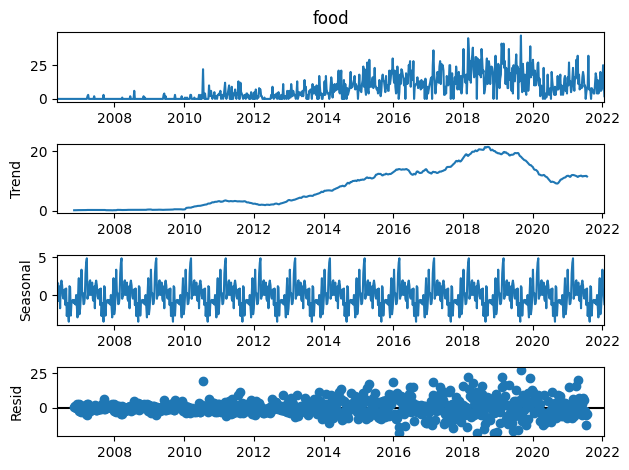

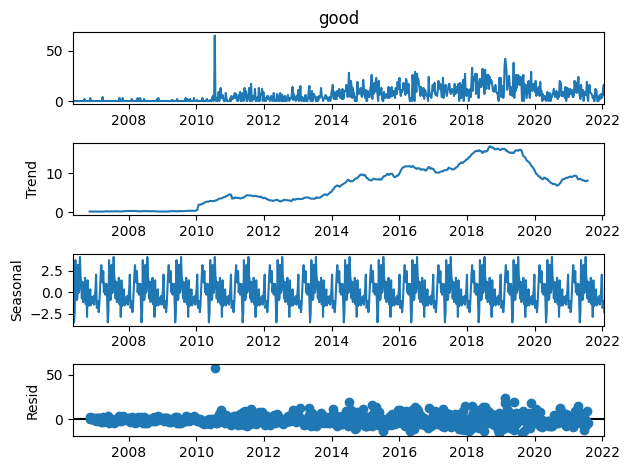

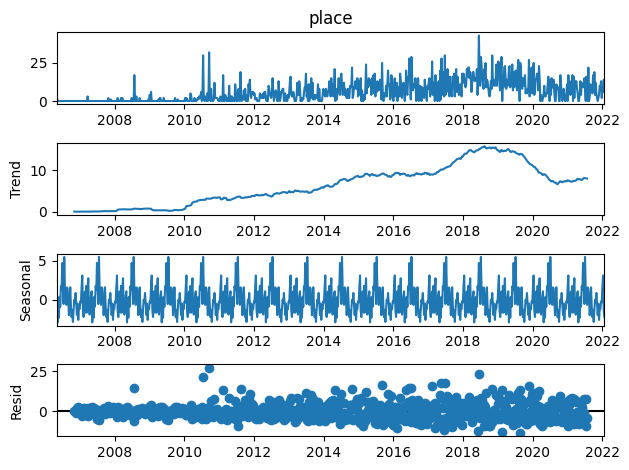

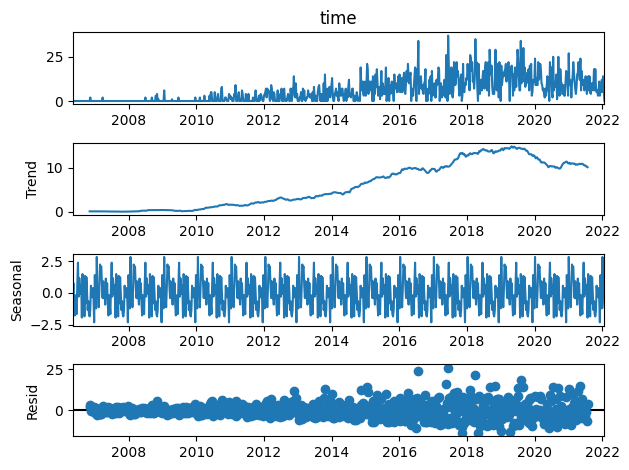

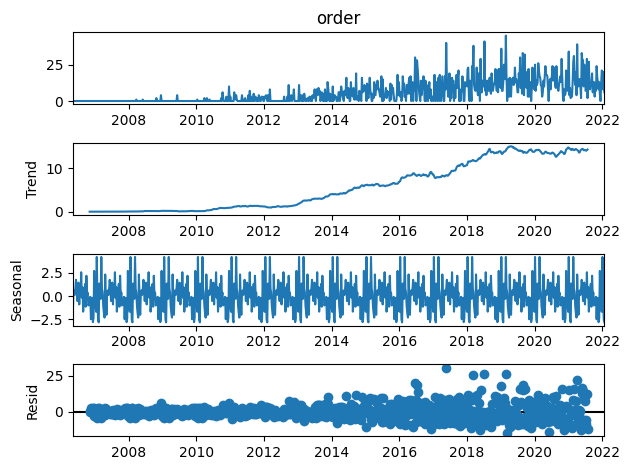

In [9]:
# Iterate through the top 5 words and plot the seasonal decomposition
for i in df3.columns[:5]:
    result = seasonal_decompose(df3[i], model='additive', period=52)
    result.plot()
    plt.show()

In [ ]:
# Find the best parameters for the ARIMA model with pm.auto_arima
for i in df3.columns[:5]:
    stepwise_model = auto_arima(df3[i], start_p=1, start_q=1,max_p=5, max_q=5, m=52,seasonal=True)
    print(i)
    print(stepwise_model.aic())
    print(stepwise_model.order)

food
5326.684638534965
(0, 1, 2)
good
5225.6075791912335
(0, 1, 2)
place
5117.833385609826
(0, 1, 2)
time
4945.626169682777
(0, 1, 1)
order
5180.271013175743
(0, 1, 1)


### Arima

In [21]:
# Forecasting with ARIMA
# Split the data into train and test
train = df3.iloc[:int(len(df3)*0.9)]
test = df3.iloc[int(len(df3)*0.9):]

In [22]:
# Create a function to calculate the arima model for each word
def arima_model(word,order):
    # Fit the model
    model = ARIMA(train[word], order=order, freq='W')
    model = model.fit()
    # Forecast
    forecast = model.forecast(len(test))
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(train[word], label='Train')
    plt.plot(test[word], label='Test')
    plt.plot(forecast, label='Forecast')
    plt.legend(loc='best')
    plt.show()
    # Calculate the MAPE
    mape = mean_absolute_percentage_error(test[word], forecast)
    print('MAPE:', mape)
    rmse = np.sqrt(mean_squared_error(test[word], forecast))
    print('RMSE:', rmse)
    r2 = r2_score(test[word], forecast)
    print('R2:', r2)

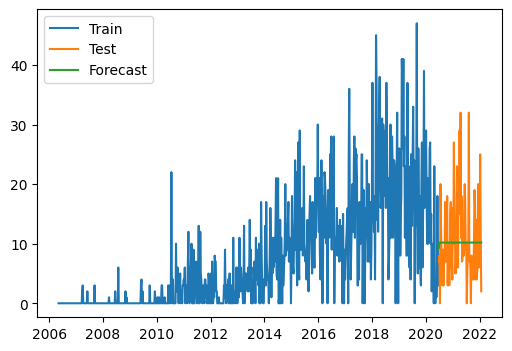

MAPE: 1658243153719196.5
RMSE: 6.963732856989571
R2: -0.005315101941953282


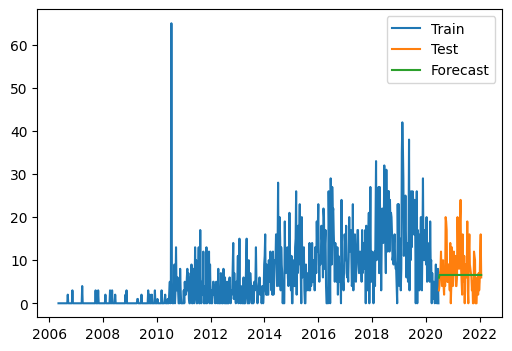

MAPE: 2852926258690193.0
RMSE: 5.708297425992135
R2: -0.06991020037472717


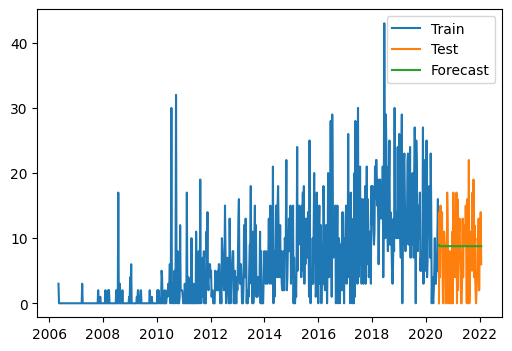

MAPE: 7624699157070038.0
RMSE: 5.782591440774236
R2: -0.052578880593266986


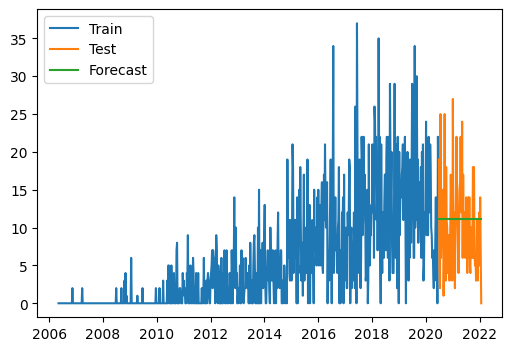

MAPE: 603757343370358.0
RMSE: 6.074995916377258
R2: -0.031819988556823775


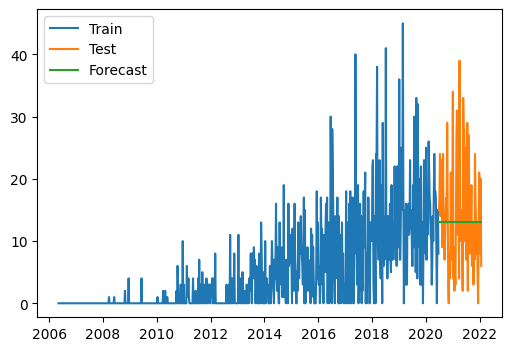

MAPE: 1419199085135614.0
RMSE: 8.705243512662731
R2: -0.009082940499727465


In [23]:
arima_model('food', (0, 1, 2))
arima_model('good', (0, 1, 2))
arima_model('place', (0, 1, 2))
arima_model('time', (0, 1, 1))
arima_model('order', (0, 1, 1))

In [25]:
# Create a function to calculate the sarimax model for each word
def sarimax_model(word,x,y,z):
    # Fit the model
    SARIMAX_model = SARIMAX(train['food'], order=(x, y, z), seasonal_order=(x, y, z, 52), freq='W')
    SARIMAX_model = SARIMAX_model.fit()
    # Forecast
    forecast = SARIMAX_model.forecast(len(test))
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(train[word], label='Train')
    plt.plot(test[word], label='Test')
    plt.plot(forecast, label='Forecast')
    plt.legend(loc='best')
    plt.show()
    # Calculate the MAPE
    mape = mean_absolute_percentage_error(test[word], forecast)
    print('MAPE:', mape)
    rmse = np.sqrt(mean_squared_error(test[word], forecast))
    print('RMSE:', rmse)
    r2 = r2_score(test[word], forecast)
    print('R2:', r2)

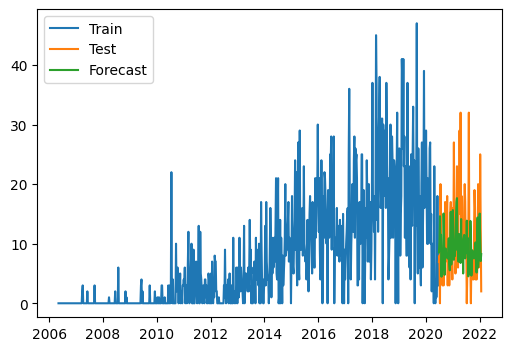

MAPE: 2139695898569495.5
RMSE: 7.69146365882515
R2: -0.22641085757803858


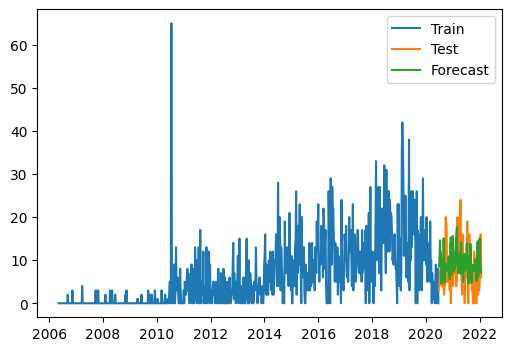

MAPE: 3652215372606234.0
RMSE: 6.700514206544142
R2: -0.47417962882509745


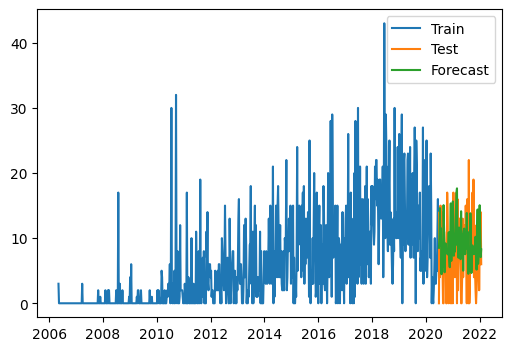

MAPE: 8905413915651231.0
RMSE: 6.68566008004039
R2: -0.4070133484695946


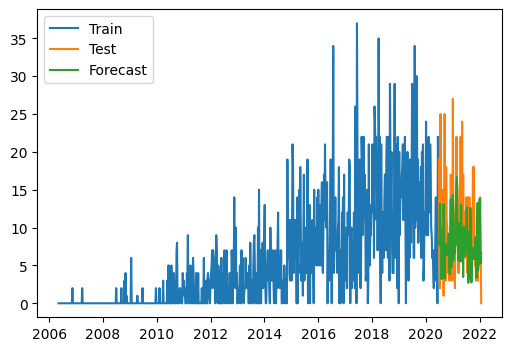

MAPE: 361672805605858.25
RMSE: 6.906834725841276
R2: -0.3337366453696353


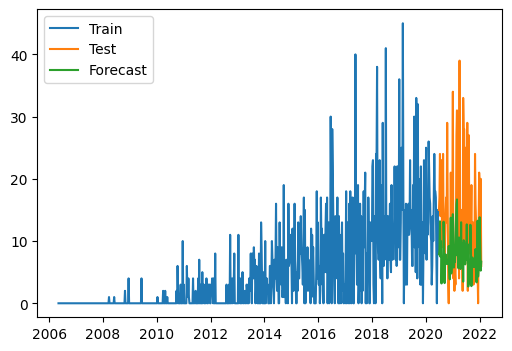

MAPE: 732583902562269.6
RMSE: 10.553946780495162
R2: -0.4831832609817881


In [26]:
sarimax_model('food', 0, 1, 2)
sarimax_model('good', 0, 1, 2)
sarimax_model('place', 0, 1, 2)
sarimax_model('time', 0, 1, 1)
sarimax_model('order', 0, 1, 1)

In [27]:
# Create a function to calculate the exponential smoothing model for each word
def exp_smoothing_model(word):
    # Fit the model
    model = ExponentialSmoothing(train[word], trend='add', seasonal='add', seasonal_periods=52)
    model = model.fit()
    # Forecast
    forecast = model.forecast(len(test))
    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(train[word], label='Train')
    plt.plot(test[word], label='Test')
    plt.plot(forecast, label='Forecast')
    plt.legend(loc='best')
    plt.show()
    # Calculate the MAPE
    mape = mean_absolute_percentage_error(test[word], forecast)
    print('MAPE:', mape)
    rmse = np.sqrt(mean_squared_error(test[word], forecast))
    print('RMSE:', rmse)
    r2 = r2_score(test[word], forecast)
    print('R2:', r2)

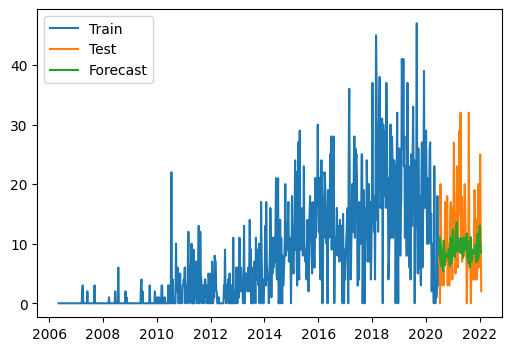

MAPE: 1817029967795955.2
RMSE: 7.250319650088143
R2: -0.08976363114425046


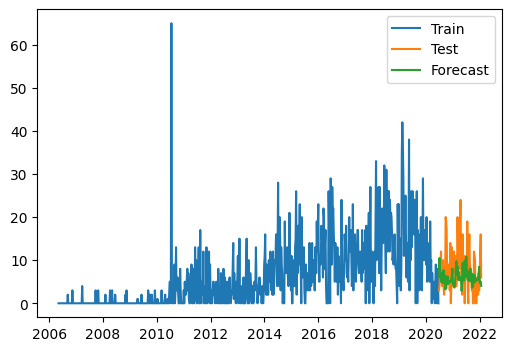

MAPE: 2588637089689217.5
RMSE: 6.164856740560824
R2: -0.24790095951229563


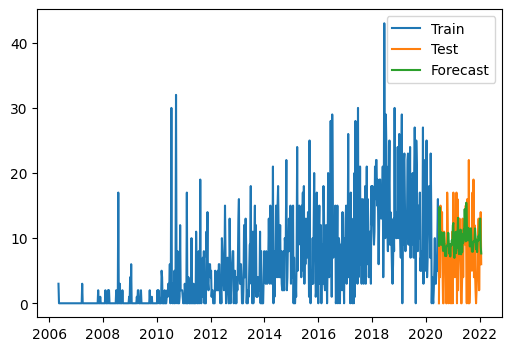

MAPE: 8204281725531539.0
RMSE: 6.191018570835096
R2: -0.20651811604361003


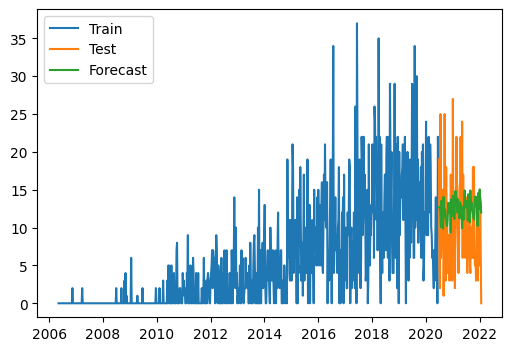

MAPE: 650120482366042.4
RMSE: 6.737198951775339
R2: -0.2690265285678075


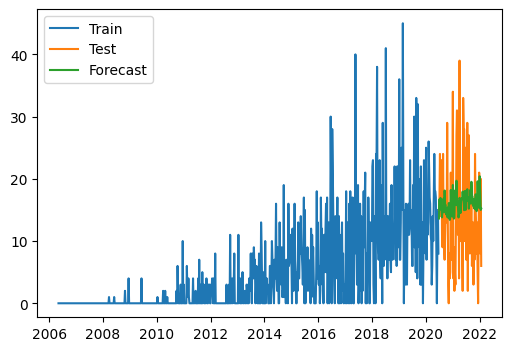

MAPE: 1782822408599021.5
RMSE: 8.948055587032178
R2: -0.06615994525026725


In [28]:
exp_smoothing_model('food')
exp_smoothing_model('good')
exp_smoothing_model('place')
exp_smoothing_model('time')
exp_smoothing_model('order')

In [52]:
# Run prophet with food
# Create a dataframe with the date and the count of food from df3 and rename the columns and fit the model columns y and ds
def prophet_model(word):
    df4 = test[[word]]
    df4 = df4.reset_index()
    df4.columns = ['ds', 'y']
    # Fit the model
    model = Prophet()
    model.fit(df4)
    # Create a dataframe with the future dates
    future = model.make_future_dataframe(periods=len(test))
    # Forecast
    forecast = model.predict(future)
    # Plot the forecast againts the test data
    model.plot(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]])
    plt.plot(df4['ds'], df4['y'], label='Test')
    #performance_metrics
    performance_metrics(forecast)


19:29:57 - cmdstanpy - INFO - Chain [1] start processing
19:29:57 - cmdstanpy - INFO - Chain [1] done processing


KeyError: 'cutoff'

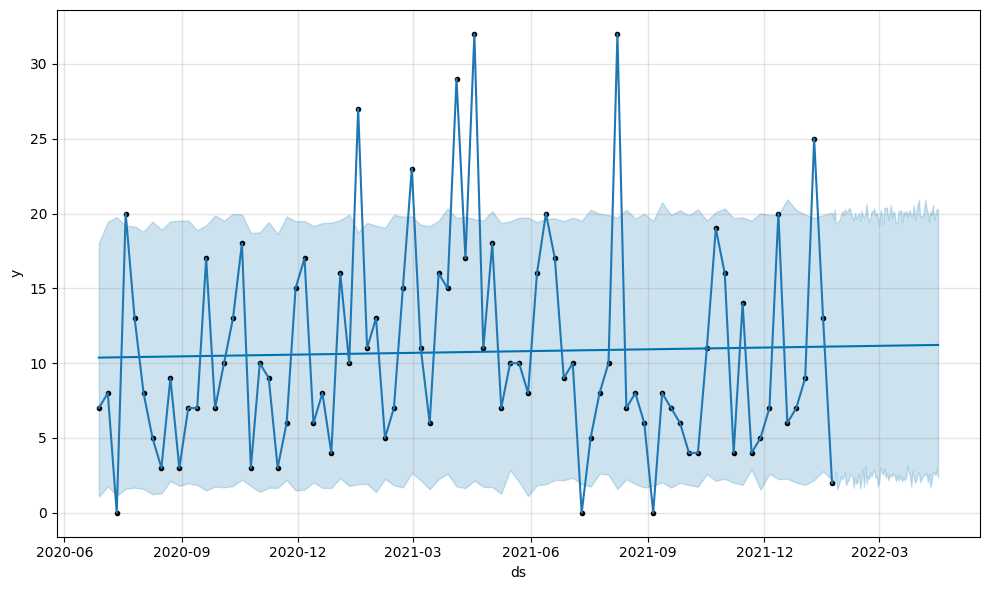

In [53]:
prophet_model('food')
prophet_model('good')
prophet_model('place')
prophet_model('time')
prophet_model('order')